<a href="https://colab.research.google.com/github/heokwon/Survey-analysis/blob/main/Survey_TFIDF_WordCloud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## install 후 런타임 다시시작 실행 -> install제외하고 다시실행

In [ ]:
!pip install konlpy
!pip install wordcloud

!pip install pyLDAvis

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 567 kB/s 
     |████████████████████████████████| 453 kB 45.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 30.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=a506c20c981bd64c8d4ad917fec770dc8c70c6280795adf8d45277881d9a04e7
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=83d2c3

In [ ]:
import pickle
import gensim
import numpy as np
import spacy

from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora import Dictionary
import nltk
from nltk.util import ngrams
from nltk import word_tokenize
from nltk import ConditionalFreqDist
from nltk.probability import ConditionalProbDist, MLEProbDist
import numpy as np
import codecs
from tqdm import tqdm
import random
import numpy as np
import re
import pandas as pd
from konlpy.tag import Okt
from future.utils import iteritems
from collections import Counter
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from PIL import Image
import matplotlib as mpl
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rcParams
import seaborn as sns
from wordcloud import WordCloud
import pyLDAvis.gensim_models
# 브라우저에서 바로 그려지도록 
# %matplotlib inline

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# # Colab 의 한글 폰트 설정
# plt.rc('font', family='NanumSquareRound') 

# 유니코드에서  음수 부호설정
mpl.rc('axes', unicode_minus=False)

# Seaborn 테마 설정
sns.set_theme(style="ticks", color_codes=True, font='NanumSquareRound', font_scale=2)

# 워닝 메세지 삭제
import warnings
warnings.filterwarnings(action='ignore')
## font 경로설정
font_list = [font.name for font in fm.fontManager.ttflist]
font_list
font_path = '/usr/share/fonts/truetype/nanum/NanumMyeongjo.ttf'

okt = Okt()

## 불용어 사전
stop_words = '수, nan, 없다, P, 없음, 등, 않은, 이, 의, 있, 하, 것, 들, 그, 되, 보, 않, 없, 나, 주, 같, 때, 도, 을, 는, 가, 에, 햄버거'
stop_words =  stop_words.split(', ')

## 전처리
def clean_content(content):
  cleaned = re.sub('[^가-힣ㄱ-ㅣa-zA-Z|.%]', ' ', string=str(content))
  cleaned = re.sub('[-=+,#/\?:^.@*\"※~ㆍ!』‘|\(\)\[\]`\'…》\”\“\’·]', ' ', cleaned)
  return cleaned

## 한단어 제거
def oneWordRemoval(lst):
  for el in lst:
    if len(el) <= 1:
      lst.remove(el)

## 불용어 제거
def del_stop(data):
  words = []
  for w in data:
    if w not in stop_words:
      words.append(w)
  return words

## WordCloud
## make_WordCloud(엑셀경로,선호하는 외부식당or선호하는 이유,넣고싶은이미지경로)
def Create_WordCloud(excel_path,column_name,Mask):
    df=pd.read_excel(excel_path)
    df['선호하는 외부식당'] = df['선호하는 외부식당'].apply(clean_content)
    df['선호하는 이유'] = df['선호하는 이유'].apply(clean_content)
    df = df[['선호하는 외부식당','선호하는 이유']]
    df = df[column_name].apply(okt.morphs, stem=True)
    df.apply(oneWordRemoval)
    df = df.apply(del_stop)

    ## TF-IDF 구축
    dictionary = gensim.corpora.Dictionary(df)
    BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in df]
    tfidf = gensim.models.TfidfModel(BoW_corpus, smartirs='ntc')

    with open('tfidf.txt', 'wb') as f:
      pickle.dump(tfidf, f)

    num = 0
    for doc in tfidf[BoW_corpus]:
      for id, freq in doc:
        num += 1

    tfidf_dic = {dictionary.get(id): freq for doc in tfidf[BoW_corpus] for id, freq in doc}

    od = {v: k for k, v in tfidf_dic.items()}
    ordered_keys = sorted(od.keys())
    tfidf_od = {od[k]: k for k in ordered_keys}

    keys = list(tfidf_od.keys())
    keys.reverse()
    for i in range(50):
      key = keys[i]
      # print(key, tfidf_od[key])

    img = Image.open(Mask) #이미지 오픈
    imgArray = np.array(img) # 이미지의 각 셀을 수치로 변환

    cloud = WordCloud(background_color='white',
                      width=2500,
                      height=1800,
                      # max_words=10,
                      mask = imgArray,
                      colormap='tab10',
                      prefer_horizontal=1.0,
                      font_path=font_path).fit_words(tfidf_od)

    plt.figure(figsize = (20, 12)) 
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(column_name, size = 20) # 제목 지정

    plt.show()

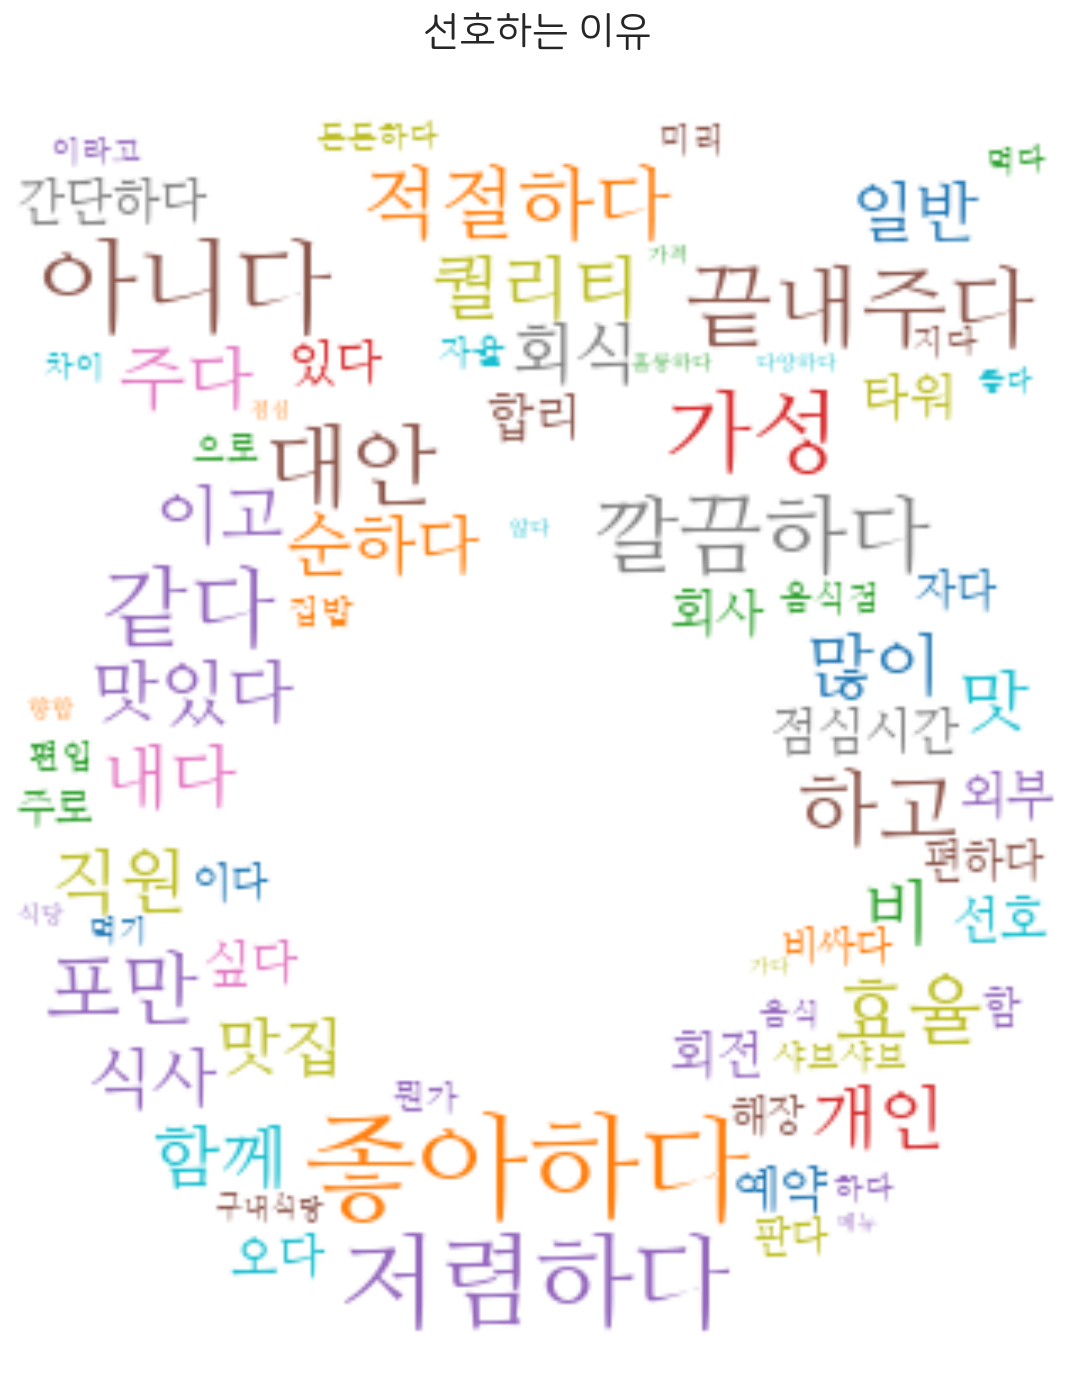

In [ ]:
excel_path = '/content/re_NH_Survey.xlsx'
Mask = '/content/NH_logo.png'

Create_WordCloud(excel_path,'선호하는 이유',Mask)